# CAPTCHA Generation & Recognition  

**Course: computer vision**

**Assignment: CA2**

**Author: Mahdy Mokhtari** 

**Student ID: 810101515**

---

### Project Overview  
This project focuses on **image processing**, **CAPTCHA generation**, **denoising**, **deblurring**, **segmentation**, and **character recognition without machine learning (Non-ML OCR)**.  
You will generate your own CAPTCHA dataset, apply classical image processing pipelines, segment characters, and finally recognize characters using similarity-based metrics.

The notebook contains four main parts, following the assignment specification.

---

### Part 1 — Data Generation (Captcha Generation)  
In this section:

- Generate **10 CAPTCHA images**, each containing **3 random characters** (lowercase English letters + digits).  
- Use **Pillow** to render the images.  
- Add **salt & pepper noise** to each image and compare with the originals.  
- Apply a **blurring kernel** of your choice and explain the reason behind choosing that kernel.

**Expected Output:**  
A final set of CAPTCHA images + noisy versions + blurred versions.

---

### Part 2 — Preprocessing  
You will apply classical preprocessing techniques to improve image quality:

- Explain why blurring kernels can remove noise.  
- Use a *different* kernel from Part 1 to reduce noise as much as possible.  
- Apply **Sharpening** or **De-blurring** (research-based) and justify your choice.  
- Perform **thresholding** to create clean binary images suitable for segmentation.

---

### Part 3 — Segmentation  
Steps:

- Extract all characters from each CAPTCHA image using binary segmentation.  
- Report number of extracted characters per sample.  
- Resize each segmented character to **64×64** pixels.  
- Save all segmented characters in a dedicated folder.

---

### Part 4 — Character Recognition  
Using the provided **Mapset** (reference characters):

- Use **non-learning similarity methods**, such as:
  - Correlation  
  - Statistical measures  
  - Structural similarity  
  - Feature-based distance metrics  
- Match each segmented character to its closest reference character.  
- Save final results and accuracy metrics in a **CSV file**.

---

### Allowed Libraries  
You are free to use standard Python image-processing libraries:  

- **OpenCV (cv2)**  
- **Pillow (PIL)**  
- **NumPy**  
- **Matplotlib**  
- **scipy** (for filters, correlations, convolution, etc.)


## Captcha Generation

### Generate 10 captcha images

In [47]:
import os
import random
import string
from PIL import ImageFilter, ImageFont, ImageDraw, Image
import shutil
import numpy as np
import cv2


OUT_DIR = "Captcha"
os.makedirs(OUT_DIR, exist_ok=True)


WIDTH, HEIGHT = 200, 100
N_SAMPLES = 10
CHARS = string.ascii_lowercase + string.digits
FONT_SIZE = 40

In [48]:



font = ImageFont.truetype("arial.ttf", FONT_SIZE)

def generate_captcha(text):
    
    img = Image.new("RGB", (WIDTH, HEIGHT), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    
    bbox = draw.textbbox((0, 0), text, font=font)
    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]
    x = (WIDTH - text_w) // 2
    y = (HEIGHT - text_h) // 2

    
    draw.text((x, y), text, font=font, fill=(0, 0, 0))

   
    text_mask = Image.new("L", (WIDTH, HEIGHT), 255)  
    mask_draw = ImageDraw.Draw(text_mask)
    mask_draw.text((x, y), text, font=font, fill=0)

    return img


print(type(CHARS))
print(CHARS)


<class 'str'>
abcdefghijklmnopqrstuvwxyz0123456789


In [49]:
# shutil.rmtree(OUT_DIR)
# shutil.rmtree(OUT_NOISE_DIR)

In [50]:
for i in range(N_SAMPLES):
    text = ''.join(random.choices(CHARS, k=3))
    img = generate_captcha(text)
    img.save(os.path.join(OUT_DIR, f"{text}_{i:02d}.png"))

print(f"{N_SAMPLES} samples '{OUT_DIR}'")

10 samples 'Captcha'


### Salt & Pepper Filter

In [51]:
OUT_NOISE_DIR = "Captcha-Noise"
os.makedirs(OUT_NOISE_DIR, exist_ok=True)

def add_salt_pepper_noise(image, amount=0.02, salt_vs_pepper=0.5):
    noisy = image.copy()
    h, w = image.shape[:2]

    num_salt = int(amount * h * w * salt_vs_pepper)
    num_pepper = int(amount * h * w * (1 - salt_vs_pepper))

    # Salt noise
    y_coords = np.random.randint(0, h, num_salt)
    x_coords = np.random.randint(0, w, num_salt)

    if image.ndim == 2:  # grayscale
        noisy[y_coords, x_coords] = 255
    else:  # color
        noisy[y_coords, x_coords] = [255, 255, 255]

    # Pepper noise
    y_coords = np.random.randint(0, h, num_pepper)
    x_coords = np.random.randint(0, w, num_pepper)

    if image.ndim == 2:  # grayscale
        noisy[y_coords, x_coords] = 0
    else:  # color
        noisy[y_coords, x_coords] = [0, 0, 0]

    return noisy

In [52]:
if os.path.exists(OUT_DIR) and os.path.isdir(OUT_DIR):
    for filename in os.listdir(OUT_DIR):
        if filename.lower().endswith(".png"):
            file_path = os.path.join(OUT_DIR, filename)

            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # or IMREAD_COLOR
            if img is None:
                print(f"Skipping unreadable file: {filename}")
                continue

            noisy_img = add_salt_pepper_noise(img, amount=0.05)

            # Save output (overwrite or change name)
            output_path = os.path.join(OUT_NOISE_DIR, f"noisy_{filename}")
            cv2.imwrite(output_path, noisy_img)
            print(f"Saved noisy image: {output_path}")

else:
    print("OUT_DIR does not exist.")

Saved noisy image: Captcha-Noise\noisy_2hr_02.png
Saved noisy image: Captcha-Noise\noisy_83z_01.png
Saved noisy image: Captcha-Noise\noisy_hfx_05.png
Saved noisy image: Captcha-Noise\noisy_j1k_07.png
Saved noisy image: Captcha-Noise\noisy_jth_06.png
Saved noisy image: Captcha-Noise\noisy_l5s_04.png
Saved noisy image: Captcha-Noise\noisy_nd0_08.png
Saved noisy image: Captcha-Noise\noisy_pkn_00.png
Saved noisy image: Captcha-Noise\noisy_qch_09.png
Saved noisy image: Captcha-Noise\noisy_x0f_03.png


Now we are comparing the original generated vs the salt and pepper noise applyed images.


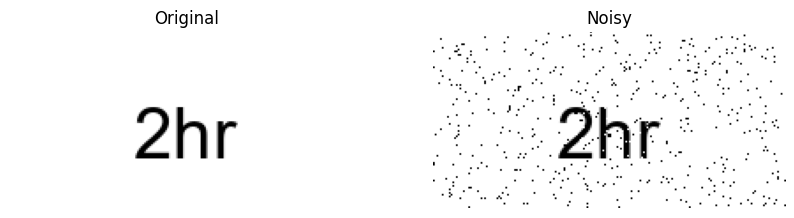

In [54]:
import matplotlib.pyplot as plt

files_out = sorted([f for f in os.listdir(OUT_DIR) if f.lower().endswith(".png")])
files_noise = sorted([f for f in os.listdir(OUT_NOISE_DIR) if f.lower().endswith(".png")])

idx = 0 

img1_path = os.path.join(OUT_DIR, files_out[idx])
img2_path = os.path.join(OUT_NOISE_DIR, files_noise[idx])

img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img1, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Noisy")
plt.imshow(img2, cmap='gray')
plt.axis("off")

plt.show()


### Gaussian BLur

This kernal is one of the kernels that does the blur filtering on an image. We had other choices like mean but this one for captcha is better because its a weighted blur so the picture will not loose its identity in the sense of we have characters and the rest is white so regular mean could cuase the characters to not be recognized even by humnas.

-  Gaussian blur preserves shapes better.

-  Gaussian kernels model real-world blur

In [53]:
OUT_NOISE_BLUR_DIR = "Captcha-Noise-Blur"
os.makedirs(OUT_NOISE_BLUR_DIR, exist_ok=True)


if os.path.exists(OUT_NOISE_DIR) and os.path.isdir(OUT_NOISE_DIR):
    for filename in os.listdir(OUT_NOISE_DIR):

        if filename.lower().endswith(".png"):
            input_path = os.path.join(OUT_NOISE_DIR, filename)
            output_path = os.path.join(OUT_NOISE_BLUR_DIR, filename)

            img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Skipping unreadable file: {filename}")
                continue

            # Gaussian blur
            blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

            cv2.imwrite(output_path, blurred_img)
            print(f"Blurred image saved: {output_path}")

else:
    print("DIR_NOISE_OUT does not exist.")

Blurred image saved: Captcha-Noise-Blur\noisy_2hr_02.png
Blurred image saved: Captcha-Noise-Blur\noisy_83z_01.png
Blurred image saved: Captcha-Noise-Blur\noisy_hfx_05.png
Blurred image saved: Captcha-Noise-Blur\noisy_j1k_07.png
Blurred image saved: Captcha-Noise-Blur\noisy_jth_06.png
Blurred image saved: Captcha-Noise-Blur\noisy_l5s_04.png
Blurred image saved: Captcha-Noise-Blur\noisy_nd0_08.png
Blurred image saved: Captcha-Noise-Blur\noisy_pkn_00.png
Blurred image saved: Captcha-Noise-Blur\noisy_qch_09.png
Blurred image saved: Captcha-Noise-Blur\noisy_x0f_03.png


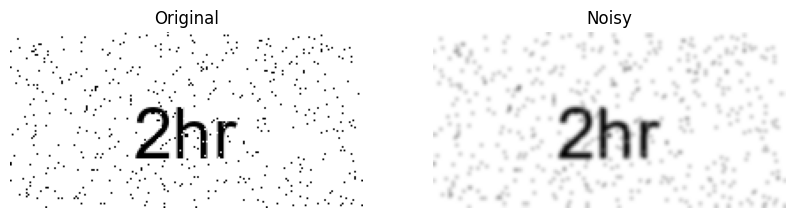

In [58]:
import matplotlib.pyplot as plt

files_noise = sorted([f for f in os.listdir(OUT_NOISE_DIR) if f.lower().endswith(".png")])
files_noise_blurred = sorted([f for f in os.listdir(OUT_NOISE_BLUR_DIR) if f.lower().endswith(".png")])

idx = 0 

img1_path = os.path.join(OUT_NOISE_DIR, files_noise[idx])
img2_path = os.path.join(OUT_NOISE_BLUR_DIR, files_noise_blurred[idx])

img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img1, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Noisy")
plt.imshow(img2, cmap='gray')
plt.axis("off")

plt.show()


## Data Pre-processing


### Removing Noise
#### Why do filters that blur an image, also can remove some noises?

To reason to this is that when we are bluring we are smoothing the pixels and getting the newr by pixels more near and less distance in terms of pixel values. The noises are mostly some unwanted pixels in the middle of other pixels that differ from neighboring pixels and the bluring becasue it gets them more to be alike in terms of value the noises some how get smoother and disapear in some degree.

In [68]:
import os
import cv2

OUT_CLEANED_DIR = "Captcha-Cleaned"
os.makedirs(OUT_CLEANED_DIR, exist_ok=True)

for filename in os.listdir(OUT_NOISE_BLUR_DIR):
    if filename.lower().endswith(".png"):
        input_path = os.path.join(OUT_NOISE_BLUR_DIR, filename)
        output_path = os.path.join(OUT_CLEANED_DIR, filename)

        img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping unreadable file: {filename}")
            continue

        cleaned_img = cv2.medianBlur(img, 5)

        cv2.imwrite(output_path, cleaned_img)
        print(f"Cleaned image saved: {output_path}")



Cleaned image saved: Captcha-Cleaned\noisy_2hr_02.png
Cleaned image saved: Captcha-Cleaned\noisy_83z_01.png
Cleaned image saved: Captcha-Cleaned\noisy_hfx_05.png
Cleaned image saved: Captcha-Cleaned\noisy_j1k_07.png
Cleaned image saved: Captcha-Cleaned\noisy_jth_06.png
Cleaned image saved: Captcha-Cleaned\noisy_l5s_04.png
Cleaned image saved: Captcha-Cleaned\noisy_nd0_08.png
Cleaned image saved: Captcha-Cleaned\noisy_pkn_00.png
Cleaned image saved: Captcha-Cleaned\noisy_qch_09.png
Cleaned image saved: Captcha-Cleaned\noisy_x0f_03.png


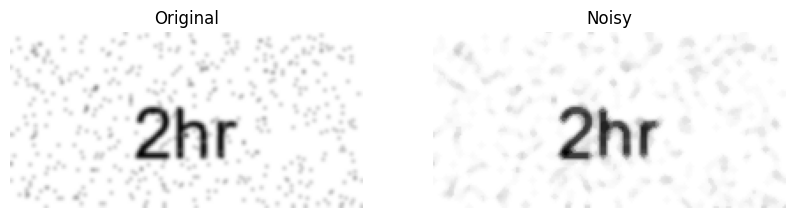

In [69]:
import matplotlib.pyplot as plt

files_noise_blurred = sorted([f for f in os.listdir(OUT_NOISE_BLUR_DIR) if f.lower().endswith(".png")])
files_cleaned = sorted([f for f in os.listdir(OUT_CLEANED_DIR) if f.lower().endswith(".png")])

idx = 0 

img1_path = os.path.join(OUT_NOISE_BLUR_DIR, files_noise_blurred[idx])
img2_path = os.path.join(OUT_CLEANED_DIR, files_cleaned[idx])

img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img1, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Noisy")
plt.imshow(img2, cmap='gray')
plt.axis("off")

plt.show()


### Removing Blur

#### What is **Sharpening** ?

Sharpening is a mehtod that we enhance the image to see better details and we shrarpen hte edges so we will see the edges more clearly. Somehow the opposite of blurring, because in bluring we make the edges disapear and smooths intensity changes but sharpening boosts intensity changes. In sharpening we are adding scaled version of the edges back to the image. Mathematically its done by subtracting a blurred version of the image from the original, then amplifying the difference. In practice


#### What is **De-blurring** ?

We exactly reverse the operation we do in bluring and here we try to reverse the convolution. Image deblurring is the mathematical process of undoing blur (convolution) using **deconvolution** techniques or AI-based restoration models.

---

**NOTE: (GPT5 Generated comparisson)**
Deblurring vs. Sharpening

| Aspect | **Sharpening** | **Deblurring** |
|:-------|:----------------|:----------------|
| **Purpose** | Enhances the *appearance* of sharpness by increasing edge contrast | Attempts to *recover* the original, unblurred image by reversing the blur process |
| **Core Idea** | Adds or amplifies high-frequency details | Performs *deconvolution* to invert the blur (convolution) mathematically |
| **Input** | Usually a normal or slightly blurred image | A noticeably blurred image |
| **Output** | Visually crisper image (but not necessarily accurate) | Restored image that approximates the true original |
| **Mathematical Model** | Edge enhancement: <br> \(\text{Sharpened} = I + \alpha (I - \text{Blur}(I))\) | Image restoration: <br> \(\hat{I} = \text{Deconvolve}(B, K)\), where \(B = I * K + N\) |
| **Requires Blur Kernel \(K\)?** | ❌ No | ✅ Yes (or estimated) |
| **Works in Frequency Domain?** | Boosts high frequencies | Reconstructs full frequency spectrum |
| **Noise Sensitivity** | Moderate — may exaggerate noise slightly | High — inversion can strongly amplify noise |
| **Techniques** | Unsharp Mask, High-Pass Filter, Laplacian | Wiener Filter, Richardson–Lucy, Blind Deconvolution |
| **Speed / Complexity** | Fast and simple (real-time possible) | Computationally expensive and iterative |
| **Goal Type** | *Perceptual enhancement* | *Physical restoration* |
| **Limitations** | Cannot restore lost detail — only fakes sharpness | Can reconstruct lost details but often unstable with unknown blur |
| **Used In** | Photography apps, image enhancement, computer vision preprocessing | Scientific imaging, microscopy, astronomy, motion correction |

---


#### Which one do we pick in our case?
According to the Gaussian blur that we have done and the task that we have is a traditional OCR, we are picking the **Richardson–Lucy De-blurring(RL)**. We could easily adjust the PSF(point spread function) and model it.
RL assumes a PSF and iteratively recovers high-frequency detail — it tends to preserve edges and works well for text/characters.

It is iterative and allows a trade-off (iterations) between recovery and artifact amplification — good for OCR tuning.

In [70]:
# shutil.rmtree(OUT_DEBLURRED_DIR)

In [71]:
import os
import cv2
import numpy as np
from skimage.restoration import richardson_lucy

OUT_CLEANED_DIR  # blurred+denoised images
OUT_DEBLURRED_DIR = "Captcha-Deblurred-RL"
os.makedirs(OUT_DEBLURRED_DIR, exist_ok=True)

def gaussian_psf(size=5, sigma=1.0):
    k1d = cv2.getGaussianKernel(size, sigma)
    psf = np.outer(k1d, k1d)
    psf /= psf.sum()
    return psf

psf = gaussian_psf(size=5, sigma=1.0)

iterations = 12

for fname in sorted(os.listdir(OUT_CLEANED_DIR)):
    if not fname.lower().endswith(".png"):
        continue
    img_path = os.path.join(OUT_CLEANED_DIR, fname)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("skip", fname)
        continue

    img_f = img.astype(np.float64) / 255.0
    pad = 10
    img_padded = cv2.copyMakeBorder(img_f, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    # Richardson Lucy De-Convolution
    deconv = richardson_lucy(img_padded, psf, num_iter=iterations, clip=False)
    deconv = deconv[pad:-pad, pad:-pad]

    deconv = np.clip(deconv, 0, 1)
    out = (deconv * 255).astype(np.uint8)

    cv2.imwrite(os.path.join(OUT_DEBLURRED_DIR, fname), out)
    print("saved", fname)


saved noisy_2hr_02.png
saved noisy_83z_01.png
saved noisy_hfx_05.png
saved noisy_j1k_07.png
saved noisy_jth_06.png
saved noisy_l5s_04.png
saved noisy_nd0_08.png
saved noisy_pkn_00.png
saved noisy_qch_09.png
saved noisy_x0f_03.png


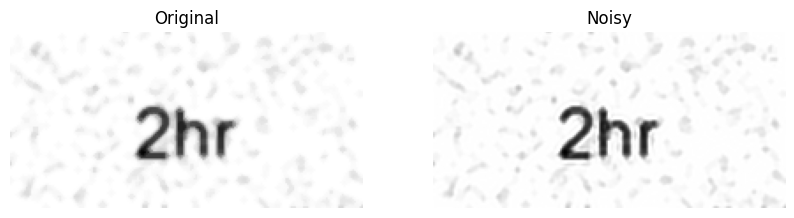

In [72]:
import matplotlib.pyplot as plt

files_cleaned = sorted([f for f in os.listdir(OUT_CLEANED_DIR) if f.lower().endswith(".png")])
files_deblured = sorted([f for f in os.listdir(OUT_DEBLURRED_DIR) if f.lower().endswith(".png")])

idx = 0

img1_path = os.path.join(OUT_CLEANED_DIR, files_cleaned[idx])
img2_path = os.path.join(OUT_DEBLURRED_DIR, files_deblured[idx])

img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img1, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Noisy")
plt.imshow(img2, cmap='gray')
plt.axis("off")

plt.show()


### Convert to Binary

In [73]:
import os
import cv2
import numpy as np

OUT_DEBLURRED_DIR
OUT_BINARY_DIR = "Captcha-Binary"
os.makedirs(OUT_BINARY_DIR, exist_ok=True)

threshold_area = 30

for fname in sorted(os.listdir(OUT_DEBLURRED_DIR)):
    if not fname.lower().endswith(".png"):
        continue
    img_path = os.path.join(OUT_DEBLURRED_DIR, fname)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("skip", fname)
        continue

    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(255 - binary, connectivity=8)

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < threshold_area:
            binary[labels == i] = 255

    cv2.imwrite(os.path.join(OUT_BINARY_DIR, fname), binary)
    print("saved", fname)


saved noisy_2hr_02.png
saved noisy_83z_01.png
saved noisy_hfx_05.png
saved noisy_j1k_07.png
saved noisy_jth_06.png
saved noisy_l5s_04.png
saved noisy_nd0_08.png
saved noisy_pkn_00.png
saved noisy_qch_09.png
saved noisy_x0f_03.png


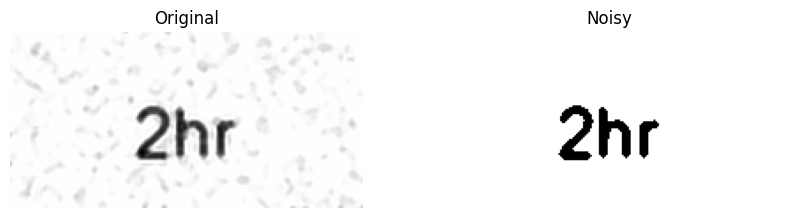

In [ ]:
import matplotlib.pyplot as plt

files_deblured = sorted([f for f in os.listdir(OUT_DEBLURRED_DIR) if f.lower().endswith(".png")])
files_binary = sorted([f for f in os.listdir(OUT_BINARY_DIR) if f.lower().endswith(".png")])

idx = 0 

img1_path = os.path.join(OUT_DEBLURRED_DIR, files_deblured[idx])
img2_path = os.path.join(OUT_BINARY_DIR, files_binary[idx])

img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Deblured")
plt.imshow(img1, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Binary")
plt.imshow(img2, cmap='gray')
plt.axis("off")

plt.show()


## Segmentation

In [ ]:
# shutil.rmtree(OUT_CHAR_DIR)

In [82]:
import os
import cv2
import numpy as np

OUT_BINARY_DIR
OUT_CHAR_DIR = "Captcha-Characters"
os.makedirs(OUT_CHAR_DIR, exist_ok=True)

character_count = 0

for fname in sorted(os.listdir(OUT_BINARY_DIR)):
    if not fname.lower().endswith(".png"):
        continue
    img_path = os.path.join(OUT_BINARY_DIR, fname)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("skip", fname)
        continue

    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    white_ratio = np.mean(binary)
    if white_ratio > 127:
        binary = 255 - binary

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    for i, contour in enumerate(contours):
        if cv2.contourArea(contour) < 50:
            continue

        x, y, w, h = cv2.boundingRect(contour)
        char_image = binary[y:y+h, x:x+w]

        # resize to 64x64
        char_resized = cv2.resize(char_image, (64, 64), interpolation=cv2.INTER_AREA)

        char_filename = f"{os.path.splitext(fname)[0]}_char_{i}.png"
        cv2.imwrite(os.path.join(OUT_CHAR_DIR, char_filename), char_resized)
        character_count += 1

print(f"Total characters extracted: {character_count}")


Total characters extracted: 29


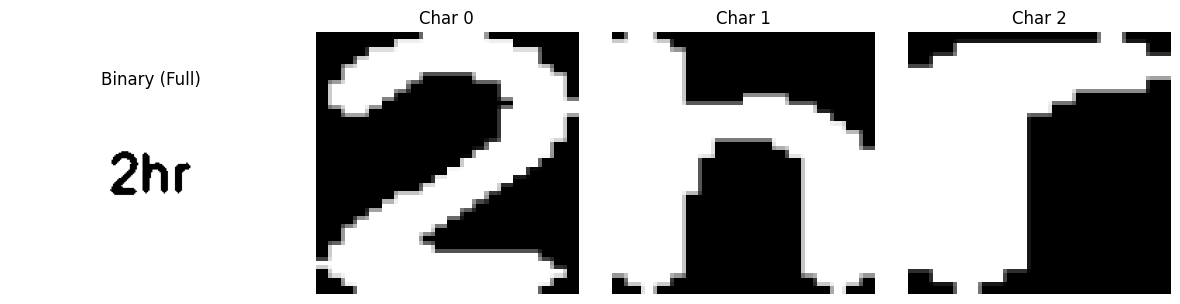

In [83]:
import matplotlib.pyplot as plt
import os
import cv2

# choose index of CAPTCHA
idx = 0  

# get binary image filenames
files_binary = sorted([f for f in os.listdir(OUT_BINARY_DIR) if f.lower().endswith(".png")])
img_name = os.path.splitext(files_binary[idx])[0]

# paths
img_path = os.path.join(OUT_BINARY_DIR, files_binary[idx])
char_files = sorted([f for f in os.listdir(OUT_CHAR_DIR) if f.startswith(img_name) and f.lower().endswith(".png")])

# load images
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
char_imgs = [cv2.imread(os.path.join(OUT_CHAR_DIR, cf), cv2.IMREAD_GRAYSCALE) for cf in char_files]

# plot original + characters
plt.figure(figsize=(12, 3))
plt.subplot(1, len(char_imgs) + 1, 1)
plt.title("Binary (Full)")
plt.imshow(img, cmap='gray')
plt.axis("off")

for i, cimg in enumerate(char_imgs):
    plt.subplot(1, len(char_imgs) + 1, i + 2)
    plt.title(f"Char {i}")
    plt.imshow(cimg, cmap='gray')
    plt.axis("off")

plt.tight_layout()
plt.show()


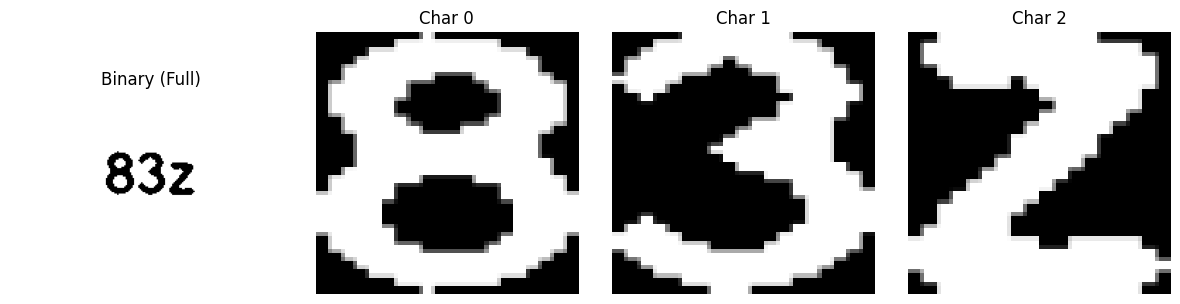

In [84]:
import matplotlib.pyplot as plt
import os
import cv2

# choose index of CAPTCHA
idx = 1  

# get binary image filenames
files_binary = sorted([f for f in os.listdir(OUT_BINARY_DIR) if f.lower().endswith(".png")])
img_name = os.path.splitext(files_binary[idx])[0]

# paths
img_path = os.path.join(OUT_BINARY_DIR, files_binary[idx])
char_files = sorted([f for f in os.listdir(OUT_CHAR_DIR) if f.startswith(img_name) and f.lower().endswith(".png")])

# load images
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
char_imgs = [cv2.imread(os.path.join(OUT_CHAR_DIR, cf), cv2.IMREAD_GRAYSCALE) for cf in char_files]

# plot original + characters
plt.figure(figsize=(12, 3))
plt.subplot(1, len(char_imgs) + 1, 1)
plt.title("Binary (Full)")
plt.imshow(img, cmap='gray')
plt.axis("off")

for i, cimg in enumerate(char_imgs):
    plt.subplot(1, len(char_imgs) + 1, i + 2)
    plt.title(f"Char {i}")
    plt.imshow(cimg, cmap='gray')
    plt.axis("off")

plt.tight_layout()
plt.show()


##  Character Recognition

In [88]:
import os
import cv2
import numpy as np
import csv

MAPSET_DIR = os.path.join("Mapset", "Mapset")
OUTPUT_CSV = "char_predictions.csv"

# load all templates (mapset)
templates = {}
for fname in sorted(os.listdir(MAPSET_DIR)):
    if not fname.lower().endswith(".png"):
        continue
    label = os.path.splitext(fname)[0]  # 'a', '3'
    path = os.path.join(MAPSET_DIR, fname)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    templates[label] = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)

results = []

for fname in sorted(os.listdir(OUT_CHAR_DIR)):
    if not fname.lower().endswith(".png"):
        continue

    seg_path = os.path.join(OUT_CHAR_DIR, fname)
    seg_img = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
    if seg_img is None:
        continue

    seg_img = cv2.resize(seg_img, (64, 64), interpolation=cv2.INTER_AREA)

    best_label = None
    best_corr = -1

    for label, tmpl in templates.items():
        seg_norm = ((seg_img - np.mean(seg_img)) / (np.std(seg_img) + 1e-6)).astype(np.float32)
        tmpl_norm = ((tmpl - np.mean(tmpl)) / (np.std(tmpl) + 1e-6)).astype(np.float32)

        # corr = cv2.matchTemplate(seg_norm, tmpl_norm, cv2.TM_CCOEFF_NORMED)[0][0]
        corr = np.mean(seg_norm * tmpl_norm)

        if corr > best_corr:
            best_corr = corr
            best_label = label

    results.append([fname, best_label, round(float(best_corr), 4)])
    print(f"{fname}: {best_label} ({best_corr:.4f})")

with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["segment_file", "prediction_label", "correlation"])
    writer.writerows(results)

print(f"\nSaved results to {OUTPUT_CSV}")


noisy_2hr_02_char_0.png: 2 (0.7949)
noisy_2hr_02_char_1.png: h (0.8268)
noisy_2hr_02_char_2.png: r (0.8522)
noisy_83z_01_char_0.png: 8 (0.7641)
noisy_83z_01_char_1.png: 3 (0.7338)
noisy_83z_01_char_2.png: z (0.8114)
noisy_hfx_05_char_0.png: h (0.8261)
noisy_hfx_05_char_1.png: h (0.3394)
noisy_j1k_07_char_0.png: j (0.6860)
noisy_j1k_07_char_1.png: 1 (0.7918)
noisy_j1k_07_char_2.png: k (0.8117)
noisy_jth_06_char_0.png: j (0.6697)
noisy_jth_06_char_1.png: t (0.7704)
noisy_jth_06_char_2.png: h (0.8106)
noisy_l5s_04_char_0.png: 9 (0.2825)
noisy_l5s_04_char_1.png: 5 (0.6833)
noisy_l5s_04_char_2.png: s (0.7175)
noisy_nd0_08_char_0.png: n (0.8186)
noisy_nd0_08_char_1.png: d (0.8243)
noisy_nd0_08_char_2.png: o (0.8412)
noisy_pkn_00_char_0.png: p (0.8196)
noisy_pkn_00_char_1.png: k (0.8220)
noisy_pkn_00_char_2.png: n (0.8523)
noisy_qch_09_char_0.png: q (0.8189)
noisy_qch_09_char_1.png: c (0.7679)
noisy_qch_09_char_2.png: h (0.7668)
noisy_x0f_03_char_0.png: x (0.6701)
noisy_x0f_03_char_1.png: o (

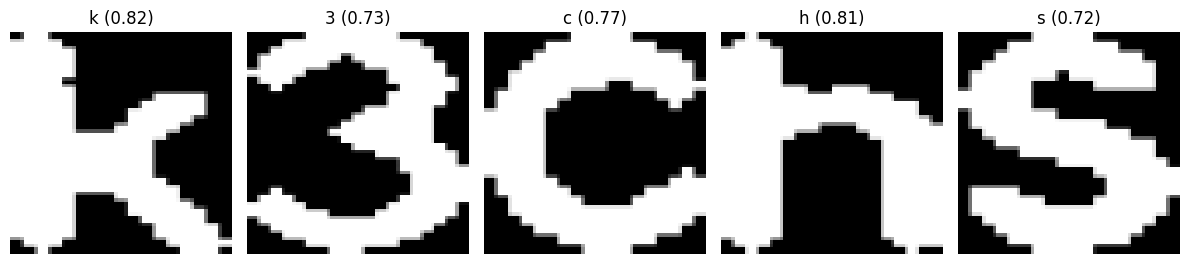

In [90]:
import os
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt


df = pd.read_csv(OUTPUT_CSV)

sample_df = df.sample(5, random_state=None).reset_index(drop=True)

# === display images with predictions ===
plt.figure(figsize=(12, 4))
for i, row in sample_df.iterrows():
    img_path = os.path.join(OUT_CHAR_DIR, row["segment_file"])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{row['prediction_label']} ({row['correlation']:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()
